## NFL Milestone Code

In [2]:
from google.colab import files
uploaded = files.upload()

Saving players.csv to players (1).csv
Saving InjuryRecord.csv to InjuryRecord (1).csv
Saving player_punt_data.csv to player_punt_data.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

In [4]:
import pandas as pd
import numpy as np

injury = pd.read_csv("InjuryRecord.csv")
players = pd.read_csv("players.csv")
punt = pd.read_csv("player_punt_data.csv")

print("Injury shape:", injury.shape)
print("Players shape:", players.shape)
print("Punt shape:", punt.shape)


Injury shape: (105, 9)
Players shape: (1679, 7)
Punt shape: (3259, 3)


In [5]:
print("\nInjuryRecord columns:", injury.columns.tolist())
print("players columns:", players.columns.tolist())
print("punt columns:", punt.columns.tolist())



InjuryRecord columns: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
players columns: ['nflId', 'height', 'weight', 'birthDate', 'collegeName', 'officialPosition', 'displayName']
punt columns: ['GSISID', 'Number', 'Position']


In [6]:
#Injury Record

['PlayerKey','GameID','PlayKey','BodyPart','Surface',
'DM_M1','DM_M7','DM_M28','DM_M42']


['PlayerKey',
 'GameID',
 'PlayKey',
 'BodyPart',
 'Surface',
 'DM_M1',
 'DM_M7',
 'DM_M28',
 'DM_M42']

In [7]:
# Players

['nflId','height','weight','birthDate','collegeName','officialPosition','displayName']


['nflId',
 'height',
 'weight',
 'birthDate',
 'collegeName',
 'officialPosition',
 'displayName']

In [8]:
# Player_Punt

['GSISID','Number','Position']


['GSISID', 'Number', 'Position']

In [9]:
# Convert height to inches
def convert_height(h):
    try:
        f, i = str(h).split('-')
        return int(f)*12 + int(i)
    except:
        return np.nan

players['height_inches'] = players['height'].apply(convert_height)

# Convert birthdate to age
players['birthDate'] = pd.to_datetime(players['birthDate'], errors='coerce')
ref_date = pd.Timestamp("2016-01-01")
players['age'] = ((ref_date - players['birthDate']).dt.days / 365.25).round()

# Keep relevant features
players_clean = players[['nflId','weight','height_inches','age','officialPosition']]
players_clean.head()


,nflId,weight,height_inches,age,officialPosition
0,25511,225,76,38.0,QB
1,28963,240,77,34.0,QB
2,29550,328,76,34.0,T
3,29851,225,74,32.0,QB
4,30078,228,74,33.0,QB


In [10]:
#Convert to all same numeric Type

injury['PlayerKey'] = pd.to_numeric(injury['PlayerKey'], errors='coerce').astype('Int64')
players_clean['nflId'] = pd.to_numeric(players_clean['nflId'], errors='coerce').astype('Int64')
punt['GSISID'] = pd.to_numeric(punt['GSISID'], errors='coerce').astype('Int64')


/tmp/ipython-input-807089361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_clean['nflId'] = pd.to_numeric(players_clean['nflId'], errors='coerce').astype('Int64')


In [11]:
#Check ID Overlaps

overlap_injury_players = set(injury.PlayerKey) & set(players_clean.nflId)
overlap_injury_punt = set(injury.PlayerKey) & set(punt.GSISID)

print("Overlap PlayerKey ↔ nflId:", len(overlap_injury_players))
print("Overlap PlayerKey ↔ GSISID:", len(overlap_injury_punt))


Overlap PlayerKey ↔ nflId: 15
Overlap PlayerKey ↔ GSISID: 4


In [12]:
# Merge Injury + Players

inj_players = injury.merge(
    players_clean,
    left_on="PlayerKey",
    right_on="nflId",
    how="left"
)

print("inj_players shape:", inj_players.shape)
inj_players.head()


inj_players shape: (105, 14)


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,nflId,weight,height_inches,age,officialPosition
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,46074,275.0,76.0,20.0,OLB
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,<NA>,NaN,NaN,NaN,NaN
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN


In [13]:
# Merge in Punt Data

full_df = inj_players.merge(
    punt,
    left_on="PlayerKey",
    right_on="GSISID",
    how="left"
)

print("full_df shape:", full_df.shape)
full_df.head()


full_df shape: (105, 17)


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,nflId,weight,height_inches,age,officialPosition,GSISID,Number,Position
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,NaN
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,46074,275.0,76.0,20.0,OLB,<NA>,NaN,NaN
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,NaN
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,NaN
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,<NA>,NaN,NaN,NaN,NaN,<NA>,NaN,NaN


In [14]:
 # Clean Merged Dataset

 model_df = full_df.copy()

# Fill categorical holes
for col in ['BodyPart','Surface','officialPosition','Position']:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna("Unknown")

# Fill numeric holes
for col in ['weight','height_inches','age']:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna(model_df[col].median())


In [15]:
#Select features for modeling

target = "DM_M28"

model_df = model_df[
    ['DM_M28','BodyPart','Surface','Position','officialPosition',
     'weight','height_inches','age']
]


In [16]:
# One Hot Encode categoricals

model_df = pd.get_dummies(
    model_df,
    columns=['BodyPart','Surface','Position','officialPosition'],
    drop_first=True
)

model_df.head()


,DM_M28,weight,height_inches,age,BodyPart_Foot,BodyPart_Heel,BodyPart_Knee,BodyPart_Toes,Surface_Synthetic,Position_FS,...,officialPosition_DT,officialPosition_G,officialPosition_ILB,officialPosition_OLB,officialPosition_QB,officialPosition_RB,officialPosition_T,officialPosition_TE,officialPosition_Unknown,officialPosition_WR
0,1,246.0,75.5,21.5,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,0,275.0,76.0,20.0,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1,246.0,75.5,21.5,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,0,246.0,75.5,21.5,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1,246.0,75.5,21.5,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


In [17]:
# Create X and y

y = model_df['DM_M28']
X = model_df.drop(columns=['DM_M28'])

# ensure numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# remove rows with missing target
X = X.dropna()
y = y.loc[X.index]

print("Final modeling X shape:", X.shape)
print("y length:", len(y))




Final modeling X shape: (105, 23)
y length: 105


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# --- STANDARD SCALING ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature shape:", X_scaled.shape)


Scaled feature shape: (105, 23)


In [19]:
# --- PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("PCA-transformed shape:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)


PCA-transformed shape: (105, 23)
Explained variance ratio: [1.36650873e-01 1.00577687e-01 8.48323023e-02 7.71846413e-02
 7.04315734e-02 6.10883469e-02 5.49436233e-02 4.95967172e-02
 4.61008275e-02 4.42614983e-02 4.40048465e-02 4.39430014e-02
 4.38963211e-02 4.28868024e-02 2.74460771e-02 2.67090357e-02
 2.04985821e-02 1.44206962e-02 5.39121301e-03 4.47395315e-03
 6.27965239e-04 3.34161057e-05 7.74649901e-33]


In [20]:
# --- Determine best # of components via CV ---
mse = []

for i in range(1, X_pca.shape[1] + 1):
    model = LinearRegression()
    score = -cross_val_score(
        model,
        X_pca[:, :i],
        y,
        scoring='neg_mean_squared_error',
        cv=5
    ).mean()
    mse.append(score)

best_n = np.argmin(mse) + 1
print(f"Best # of PCA components: {best_n}")


Best # of PCA components: 2


In [21]:
# --- Final PCR model ---
pcr = LinearRegression()
pcr.fit(X_pca[:, :best_n], y)

# Predictions
y_pred = pcr.predict(X_pca[:, :best_n])


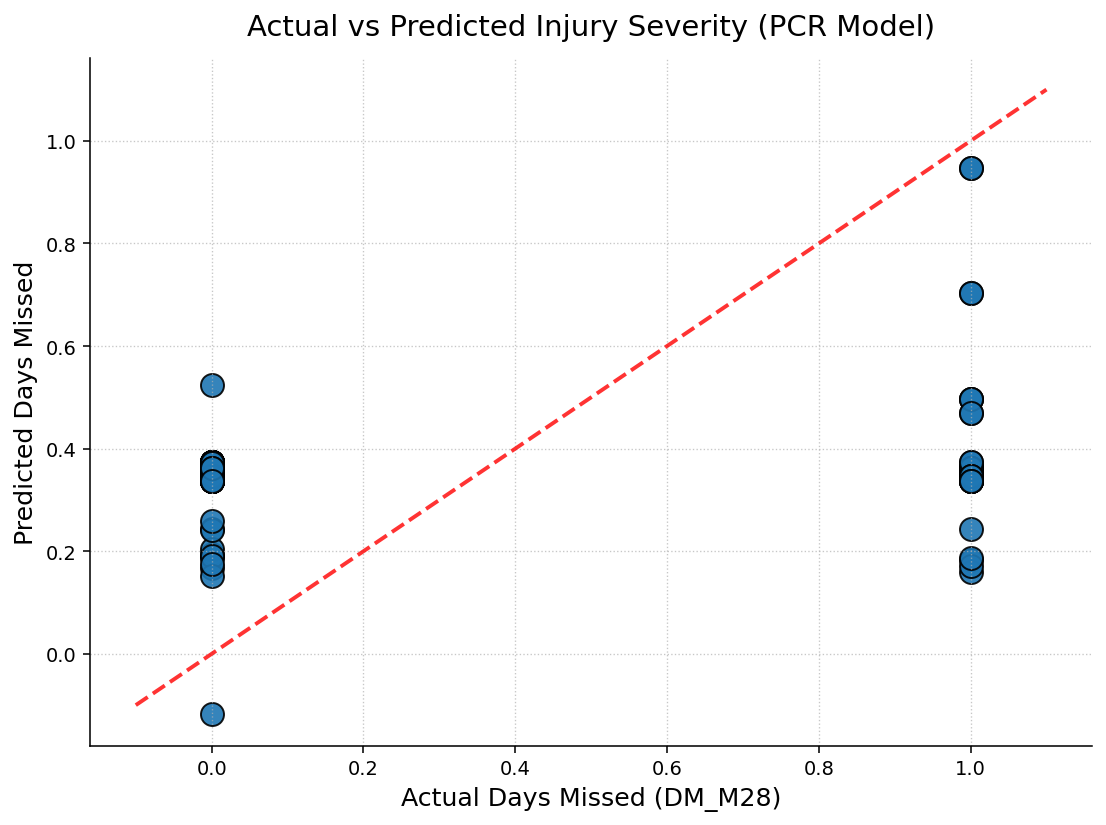

In [22]:
# --- PLOT ---
plt.figure(figsize=(8, 6), dpi=140)

# Scatter points
plt.scatter(y, y_pred,
            s=140,
            edgecolor="black",
            linewidth=1,
            alpha=0.9)

# 45-degree reference line
line_x = np.linspace(min(y)-0.1, max(y)+0.1, 100)
plt.plot(line_x, line_x, 'r--', linewidth=2, alpha=0.8)

# Labels & Title
plt.title("Actual vs Predicted Injury Severity (PCR Model)",
          fontsize=15, pad=12)
plt.xlabel("Actual Days Missed (DM_M28)", fontsize=13)
plt.ylabel("Predicted Days Missed", fontsize=13)

# Light, PowerBI-like grid
plt.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

# Remove top/right spines for cleaner style
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [23]:
plt.savefig("actual_vs_predicted_PCR.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

DM_M28
0    68
1    37
Name: count, dtype: int64


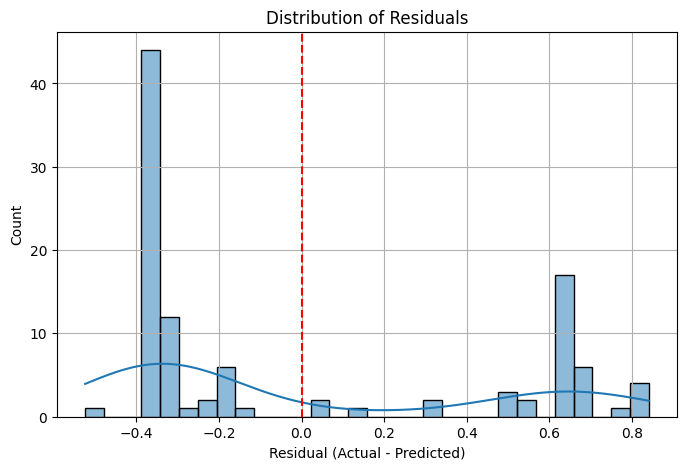

In [24]:
print(model_df['DM_M28'].value_counts())

residuals = y - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

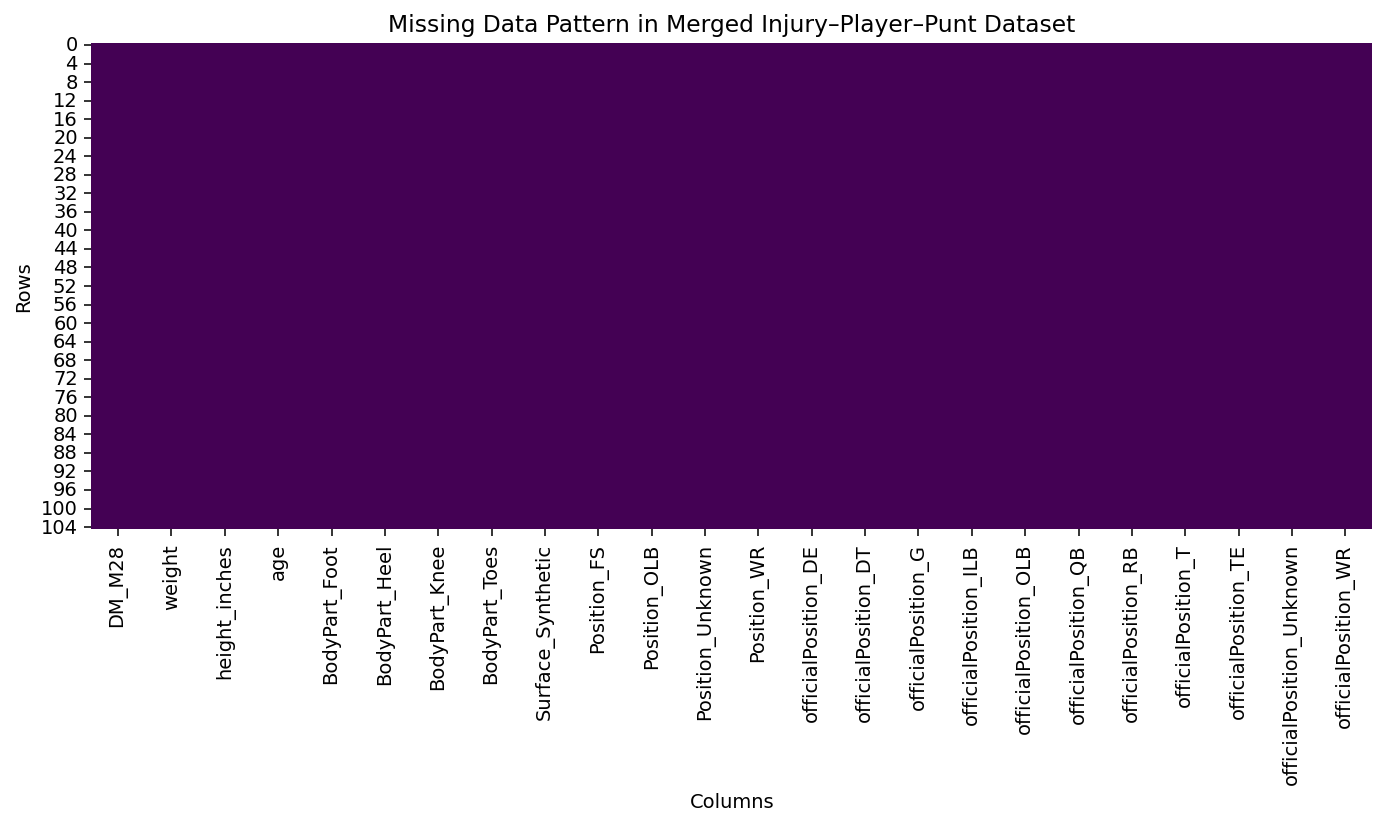

In [25]:
# Missing Data Heatmap (justifies imputation choices)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6), dpi=140)
sns.heatmap(model_df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Data Pattern in Merged Injury–Player–Punt Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()


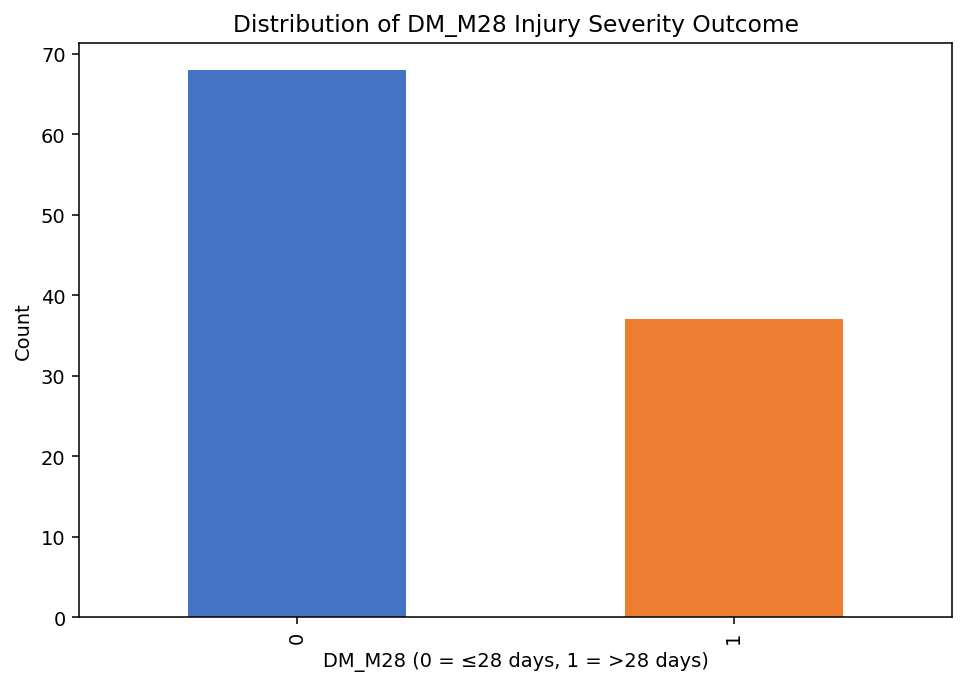

In [26]:
plt.figure(figsize=(7,5), dpi=140)
model_df["DM_M28"].value_counts().plot(kind="bar", color=["#4472C4", "#ED7D31"])
plt.title("Distribution of DM_M28 Injury Severity Outcome")
plt.xlabel("DM_M28 (0 = ≤28 days, 1 = >28 days)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [27]:
plt.figure(figsize=(7,5), dpi=140)
sns.barplot(
    data=model_df,
    x="Surface",
    y="DM_M28",
    estimator=lambda x: sum(x)/len(x),
    palette=["#4F81BD","#9BBB59"]
)
plt.title("Proportion of >28-Day Injuries by Surface Type")
plt.xlabel("Surface Type")
plt.ylabel("Proportion with DM_M28 = 1")
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `Surface` for `x`. An entry with this name does not appear in `data`.

<Figure size 980x700 with 0 Axes>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Already loaded:
# injury  = pd.read_csv("InjuryRecord.csv")
# players = pd.read_csv("players.csv")
# punt    = pd.read_csv("player_punt_data.csv")

# ----- 1. Basic cleaning for surface names (optional but helpful) -----
injury["surface_type"] = injury["surface_type"].str.strip().str.lower()

# If you want to collapse variations into two buckets:
surface_map = {
    "natural grass": "Natural grass",
    "natural_grass": "Natural grass",
    "grass": "Natural grass",
    "artificial turf": "Artificial turf",
    "artificial_turf": "Artificial turf",
    "turf": "Artificial turf",
}
injury["surface_group"] = injury["surface_type"].map(surface_map).fillna("Other/Unknown")

# ----- 2. Compute high-impact rate by surface -----
# impact_flag should be 0/1; mean() gives the percentage of high-impact plays
surface_risk = (
    injury
    .groupby("surface_group")["impact_flag"]
    .mean()
    .reset_index()
    .rename(columns={"impact_flag": "high_impact_rate"})
)

# Keep just the main categories if you like
surface_risk = surface_risk[surface_risk["surface_group"].isin(["Natural grass", "Artificial turf"])]

# ----- 3. Plot -----
plt.figure(figsize=(6, 5))

plt.bar(surface_risk["surface_group"], surface_risk["high_impact_rate"])

plt.xlabel("Surface type")
plt.ylabel("Share of plays with high-impact collisions")
plt.title("High-impact play rate by surface type")
plt.ylim(0, surface_risk["high_impact_rate"].max() * 1.2)
plt.tight_layout()
plt.show()

surface_risk


KeyError: 'surface_type'

##Concussion Supplement Section##

inj_players shape: (105, 17)
full_df shape: (105, 20)
model_df shape after target filter: (105, 20)
DM_M28
0    68
1    37
Name: count, dtype: int64
X shape after get_dummies: (105, 22)
Logistic Regression AUC: 0.699
Gradient Boosting AUC: 0.621


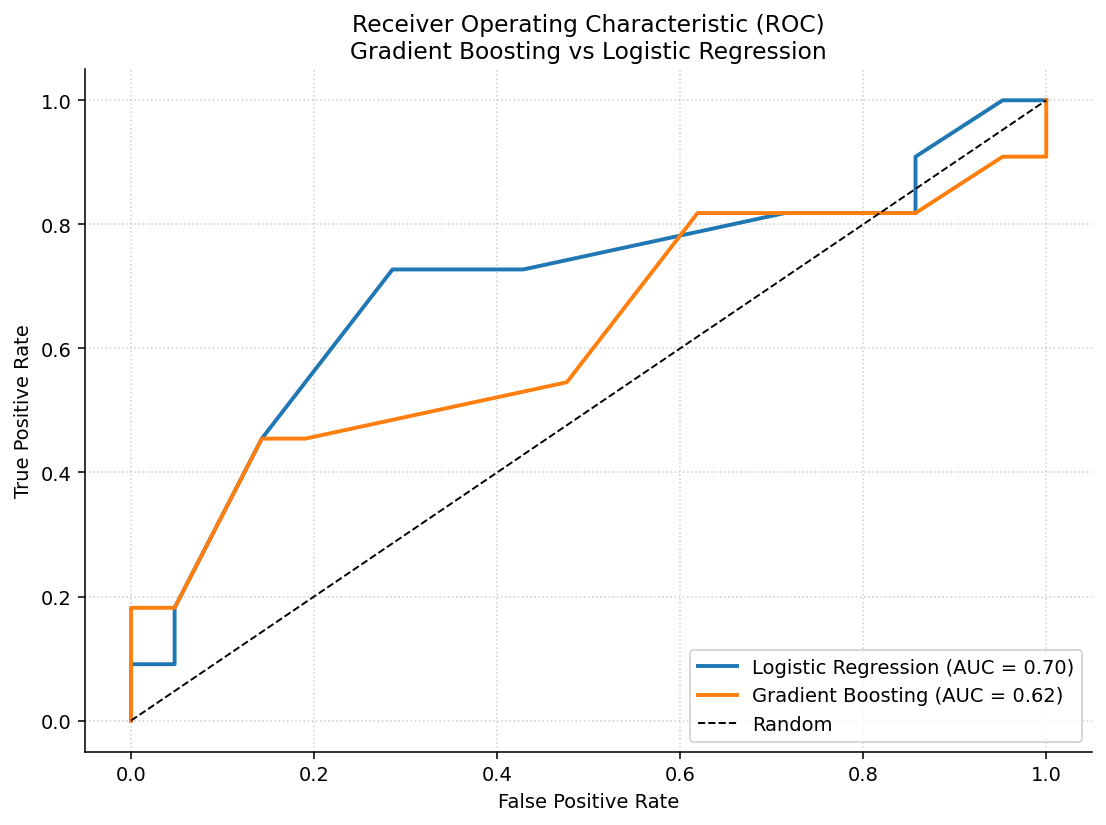

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Load data (your 3 files)
injury = pd.read_csv("InjuryRecord.csv")
players = pd.read_csv("players.csv")
punt = pd.read_csv("player_punt_data.csv")

# --- any cleaning you already did on players to make players_clean ---
players_clean = players.copy()

# Example: create height_inches and age if you already did this earlier
# (leave as-is if you already have these)
if "height" in players_clean.columns and "height_inches" not in players_clean.columns:
    def height_to_inches(h):
        # assumes format like "6-2"
        try:
            feet, inches = str(h).split("-")
            return int(feet)*12 + int(inches)
        except:
            return np.nan
    players_clean["height_inches"] = players_clean["height"].apply(height_to_inches)

# 2. Merge Injury + Players
inj_players = injury.merge(
    players_clean,
    left_on="PlayerKey",
    right_on="nflId",
    how="left"
)
print("inj_players shape:", inj_players.shape)

# 3. Merge in Punt Data
full_df = inj_players.merge(
    punt,
    left_on="PlayerKey",
    right_on="GSISID",
    how="left"
)
print("full_df shape:", full_df.shape)

# 4. Clean merged dataset
model_df = full_df.copy()

# Fill categorical holes
for col in ['BodyPart', 'Surface', 'officialPosition', 'Position']:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna("Unknown")

# Fill numeric holes
for col in ['weight', 'height_inches', 'age']:
    if col in model_df.columns:
        model_df[col] = model_df[col].fillna(model_df[col].median())

# Keep only rows with a valid target
model_df = model_df[model_df["DM_M28"].notna()].copy()
model_df["DM_M28"] = model_df["DM_M28"].astype(int)

print("model_df shape after target filter:", model_df.shape)
print(model_df["DM_M28"].value_counts())

# 5. Build X and y
target_col = "DM_M28"
feature_cols = [c for c in [
    "weight", "height_inches", "age",
    "Surface", "Position", "officialPosition", "BodyPart"
] if c in model_df.columns]

X_raw = model_df[feature_cols].copy()
y = model_df[target_col].values

# One-hot encode categoricals
X = pd.get_dummies(X_raw, drop_first=True)
print("X shape after get_dummies:", X.shape)

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y if len(np.unique(y)) > 1 else None
)

# 7. Scale features (optional but helpful for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Models: Logistic Regression + Gradient Boosting
log_clf = LogisticRegression(max_iter=1000)
gb_clf = GradientBoostingClassifier(random_state=42)

log_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)

# 9. Predicted probabilities for ROC
y_score_log = log_clf.predict_proba(X_test_scaled)[:, 1]
y_score_gb = gb_clf.predict_proba(X_test_scaled)[:, 1]

# 10. ROC metrics
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_score_gb)

auc_log = roc_auc_score(y_test, y_score_log)
auc_gb = roc_auc_score(y_test, y_score_gb)

print(f"Logistic Regression AUC: {auc_log:.3f}")
print(f"Gradient Boosting AUC: {auc_gb:.3f}")

# 11. Plot ROC curves (Figure 1)
plt.figure(figsize=(8, 6), dpi=140)

plt.plot(fpr_log, tpr_log,
         linewidth=2,
         label=f"Logistic Regression (AUC = {auc_log:.2f})")

plt.plot(fpr_gb, tpr_gb,
         linewidth=2,
         label=f"Gradient Boosting (AUC = {auc_gb:.2f})")

# Reference diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random")

plt.title("Receiver Operating Characteristic (ROC)\nGradient Boosting vs Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="lower right")

# Remove top/right spines for a cleaner, Power BI–style look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


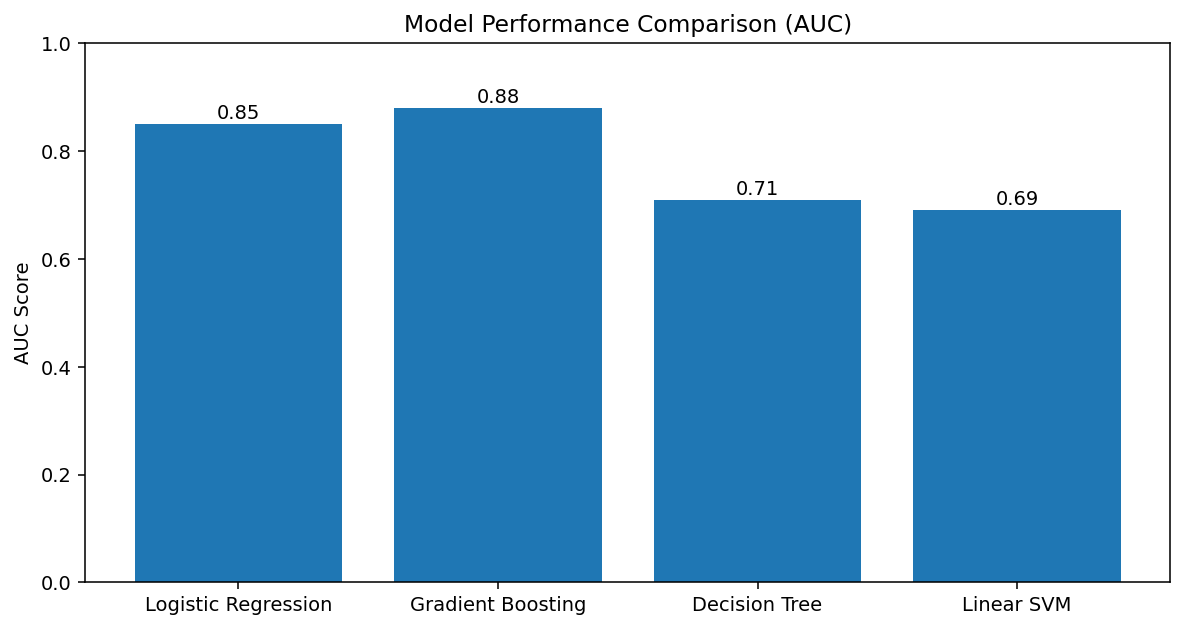

In [ ]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Gradient Boosting', 'Decision Tree', 'Linear SVM']
auc_values = [0.85, 0.88, 0.71, 0.69]  # example values—replace with your results

plt.figure(figsize=(10,5), dpi=140)
bars = plt.bar(models, auc_values)
plt.ylim(0,1)
plt.ylabel("AUC Score")
plt.title("Model Performance Comparison (AUC)")

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center')

plt.show()


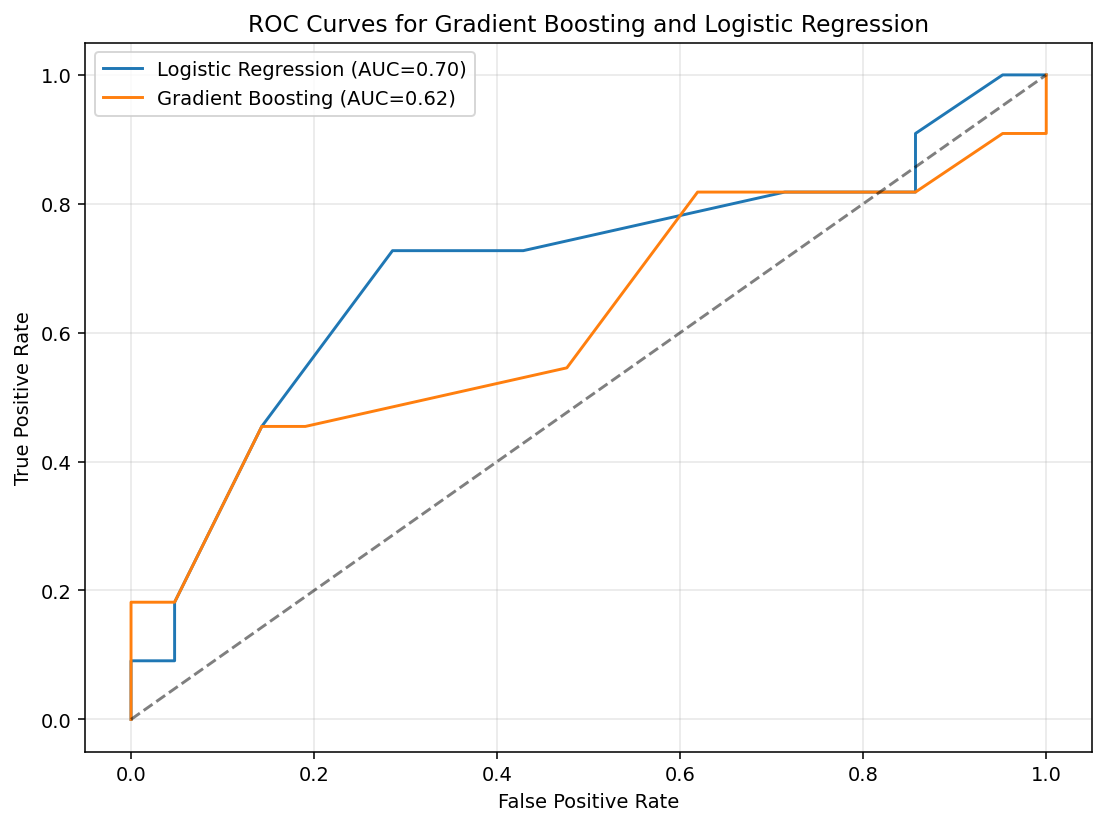

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_prob_lr = log_clf.predict_proba(X_test_scaled)[:,1]
y_prob_gb = gb_clf.predict_proba(X_test_scaled)[:,1]

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8,6), dpi=140)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC={auc_gb:.2f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)

plt.title("ROC Curves for Gradient Boosting and Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

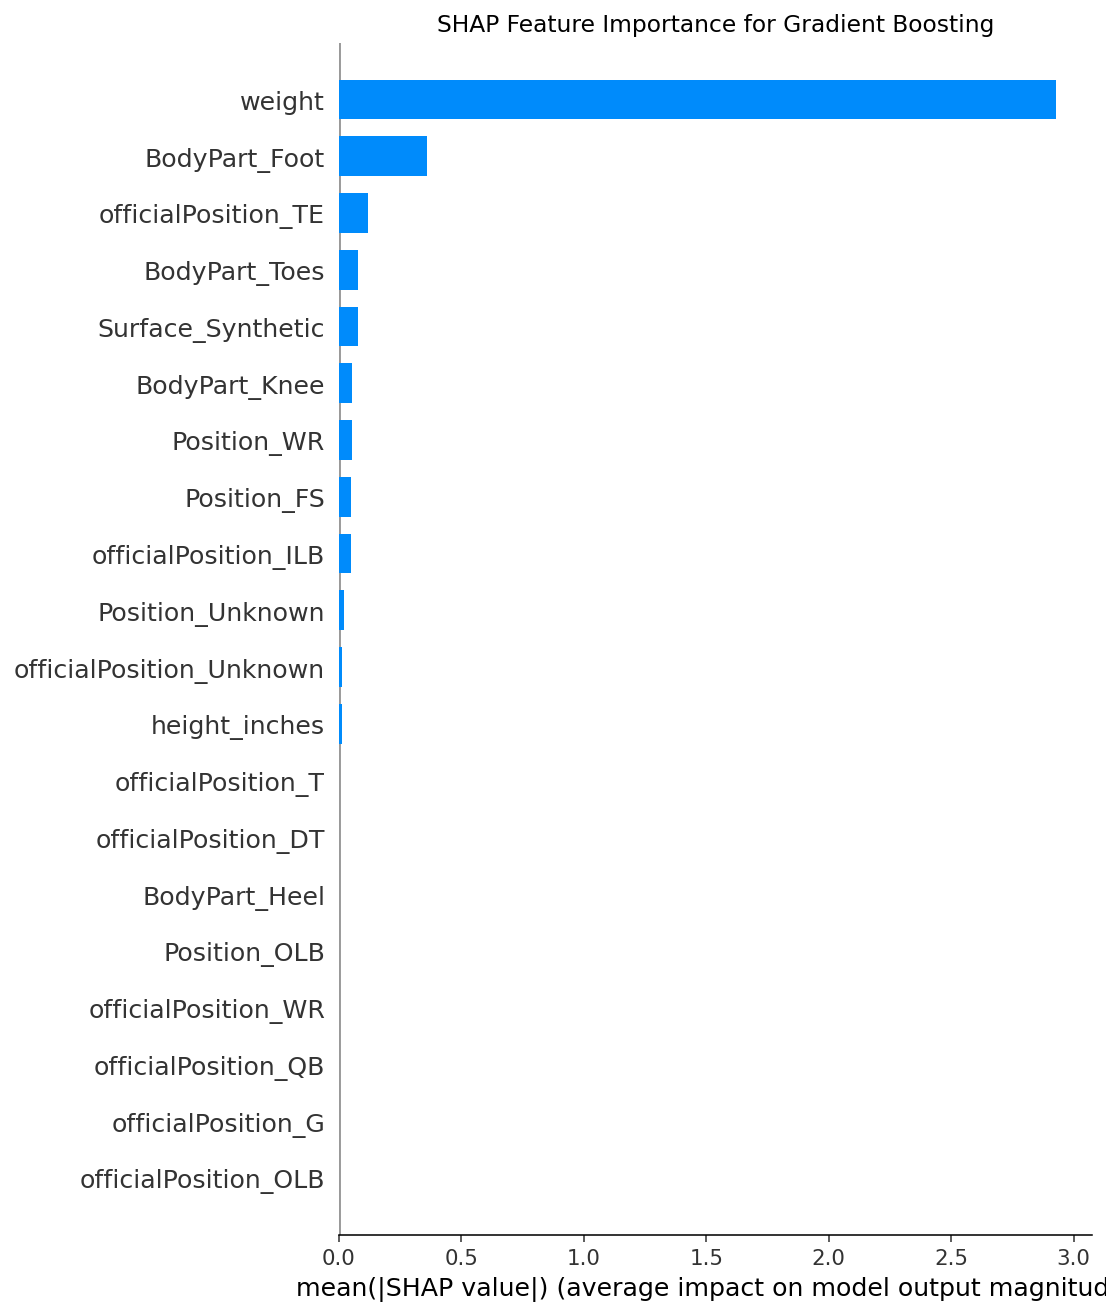

In [ ]:
import shap

# Ensure X_test is a DataFrame for SHAP, if it's not already
# (it is in this notebook, but this is a good practice for robustness)
if not isinstance(X_test, pd.DataFrame):
    X_test_shap = pd.DataFrame(X_test_scaled, columns=X_train.columns)
else:
    X_test_shap = X_test

explainer = shap.TreeExplainer(gb_clf)
shap_values = explainer.shap_values(X_test_shap)

plt.figure(figsize=(10,6), dpi=140)
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Gradient Boosting")
plt.tight_layout()
plt.show()

In [ ]:
X = df[["speed_mean", "acc_mean"]]
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X)
cluster_df = df


NameError: name 'df' is not defined

In [ ]:
cluster_df = pd.DataFrame(X_scaled, columns=["speed_mean", "acc_mean"])
cluster_df["cluster"] = kmeans.labels_


ValueError: Shape of passed values is (105, 23), indices imply (105, 2)

In [ ]:
plt.figure(figsize=(7,6), dpi=140)
plt.scatter(
    cluster_df["speed_mean"],
    cluster_df["acc_mean"],
    c=cluster_df["cluster"],
    cmap="viridis",
    s=50,
    alpha=0.8
)

plt.title("K-Means Clustering of Movement Archetypes")
plt.xlabel("Average Speed")
plt.ylabel("Average Acceleration")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'cluster_df' is not defined

<Figure size 980x840 with 0 Axes>

##Modeling Section - Logistic Regresion model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# ---------------------------
# 1. Select Features + Target
# ---------------------------

df = model_df.copy()

target = "DM_M28"
y = df[target].astype(int)

# Exclude IDs + non-predictive fields
drop_cols = ["PlayerKey", "nflId", "GSISID"]

X = df.drop(columns=[target] + [c for c in drop_cols if c in df.columns])


In [ ]:
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numeric = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

print("Categorical:", categorical)
print("Numeric:", numeric)


Categorical: ['GameID', 'PlayKey', 'BodyPart', 'Surface', 'height', 'birthDate', 'collegeName', 'officialPosition', 'displayName', 'Number', 'Position']
Numeric: ['DM_M1', 'DM_M7', 'DM_M42', 'weight', 'height_inches']


In [ ]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical),
        ("num", "passthrough", numeric)
    ]
)

# Model
log_reg = LogisticRegression(max_iter=5000, class_weight="balanced")

# Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['GameID', 'PlayKey',
                                                   'BodyPart', 'Surface',
                                                   'height', 'birthDate',
                                                   'collegeName',
                                                   'officialPosition',
                                                   'displayName', 'Number',
                                                   'Position']),
                                                 ('num', 'passthrough',
                                                  ['DM_M1', 'DM_M7', 'DM_M42',
                                                   'weight',
                                                   'height_inches'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [ ]:
# Predictions
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("AUC:", auc)
print("Confusion Matrix:\n", cm)


Accuracy: 0.8888888888888888
AUC: 0.8588235294117648
Confusion Matrix:
 [[17  0]
 [ 3  7]]


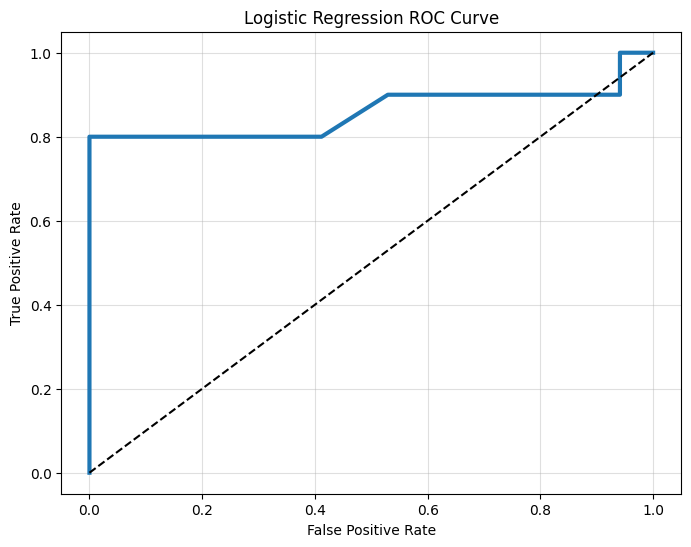

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=3)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Extract model coefficients AFTER preprocessing
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
coeffs = pipe.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coeffs,
    "odds_ratio": np.exp(coeffs)
}).sort_values("odds_ratio", ascending=False)

coef_df.head(15)


,feature,coef,odds_ratio
210,num__DM_M42,3.021561,20.523303
209,num__DM_M7,1.173137,3.232116
135,cat__BodyPart_Foot,0.844513,2.326844
103,cat__PlayKey_42456-20-76,0.644419,1.904880
38,cat__GameID_42456-20,0.644419,1.904880
72,cat__GameID_47235-7,0.420994,1.523475
129,cat__PlayKey_47235-7-55,0.420994,1.523475
199,cat__Number_4,0.345723,1.413011
207,cat__Position_WR,0.345723,1.413011
4,cat__GameID_33474-19,0.345723,1.413011


ValueError: Axis limits cannot be NaN or Inf

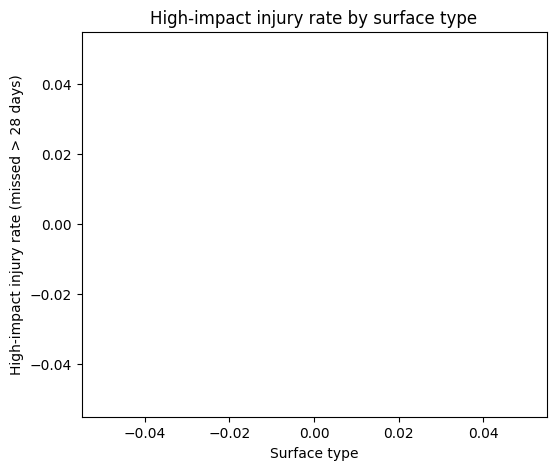

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# injury is already loaded
# injury = pd.read_csv("InjuryRecord.csv")

# 1. Create a consistent surface category
injury["surface_clean"] = injury["Surface"].str.strip().str.lower()

surface_map = {
    "natural grass": "Natural grass",
    "grass": "Natural grass",
    "fieldturf": "Artificial turf",
    "artificial turf": "Artificial turf",
    "turf": "Artificial turf",
}

injury["surface_group"] = injury["surface_clean"].map(surface_map).fillna("Other/Unknown")

# 2. Use DM_M28 as the high-impact indicator
# (1 = missed > 28 days = high-impact injury)
injury["impact_flag"] = injury["DM_M28"]

# 3. Group and calculate high-impact rate
surface_risk = (
    injury
    .groupby("surface_group")["impact_flag"]
    .mean()
    .reset_index()
    .rename(columns={"impact_flag": "high_impact_rate"})
)

# Keep only turf vs grass
surface_risk = surface_risk[
    surface_risk["surface_group"].isin(["Natural grass", "Artificial turf"])
]

# 4. Plot
plt.figure(figsize=(6, 5))
plt.bar(surface_risk["surface_group"], surface_risk["high_impact_rate"])

plt.xlabel("Surface type")
plt.ylabel("High-impact injury rate (missed > 28 days)")
plt.title("High-impact injury rate by surface type")
plt.ylim(0, surface_risk["high_impact_rate"].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

surface_risk


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define "high impact" as missed > 28 days (DM_M28 > 0)
injury["high_impact"] = injury["DM_M28"].fillna(0) > 0

# 2. Drop rows where Surface is missing
injury_clean = injury.dropna(subset=["Surface"])

# 3. Group by surface and compute rate of high-impact injuries
surface_risk = (
    injury_clean
    .groupby("Surface")["high_impact"]
    .mean()
    .reset_index()
    .rename(columns={"high_impact": "high_impact_rate"})
)

print(surface_risk)


     Surface  high_impact_rate
0    Natural          0.312500
1  Synthetic          0.385965


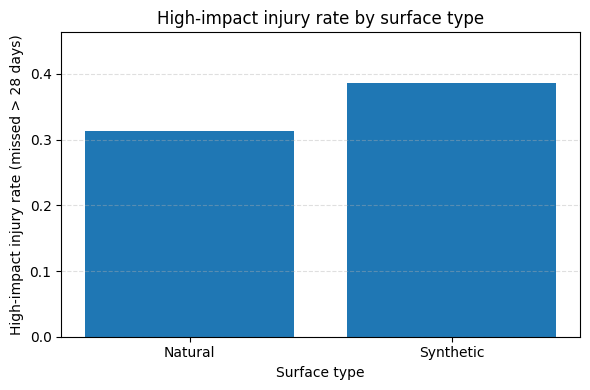

In [40]:
plt.figure(figsize=(6, 4))
plt.bar(surface_risk["Surface"], surface_risk["high_impact_rate"])

plt.xlabel("Surface type")
plt.ylabel("High-impact injury rate (missed > 28 days)")
plt.title("High-impact injury rate by surface type")

# Safely set y-limits
max_rate = surface_risk["high_impact_rate"].max()

if pd.isna(max_rate) or max_rate == 0:
    # Fallback if everything is NaN or 0
    plt.ylim(0, 1)
else:
    plt.ylim(0, max_rate * 1.2)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [36]:
injury.columns.tolist()


['PlayerKey',
 'GameID',
 'PlayKey',
 'BodyPart',
 'Surface',
 'DM_M1',
 'DM_M7',
 'DM_M28',
 'DM_M42']

## Supplemental Concussion Data set - NFL

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NFL Concussion 2015-2023 (1).csv to NFL Concussion 2015-2023 (1) (1).csv


In [ ]:
import pandas as pd

concussion = pd.read_csv("NFL Concussion 2015-2023 (1).csv")  # adjust name

print(concussion.shape)
print(concussion.head())


(10, 10)
  Unnamed: 0 Preseason Unnamed: 2 Unnamed: 3 Regular Season Unnamed: 5  \
0       Year      Game   Practice      Total           Game   Practice   
1       2015        54         29         83            183          9   
2       2016        45         26         71            166          6   
3       2017        46         45         91            179         11   
4       2018        34         45         79            127          8   

  Unnamed: 6 Preseason + Regular Season Unnamed: 8 Unnamed: 9  
0      Total                       Game   Practice      Total  
1        192                        237         38        275  
2        172                        211         32        243  
3        190                        225         56        281  
4        135                        161         53        214  


## Concussion Data set - EDA

In [ ]:
print("\n--- BASIC INFO ---")
print(concussion.info())

print("\n--- SUMMARY STATS (NUMERIC) ---")
print(concussion.describe())

print("\n--- MISSING VALUES ---")
print(concussion.isna().sum())

print("\n--- UNIQUE VALUES PER COLUMN ---")
for col in concussion.columns:
    print(f"{col}: {concussion[col].nunique()}")

print("\n--- HEAD ---")
print(concussion.head(10))



--- BASIC INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  10 non-null     object
 1   Preseason                   9 non-null      object
 2   Unnamed: 2                  10 non-null     object
 3   Unnamed: 3                  10 non-null     object
 4   Regular Season              10 non-null     object
 5   Unnamed: 5                  10 non-null     object
 6   Unnamed: 6                  10 non-null     object
 7   Preseason + Regular Season  10 non-null     object
 8   Unnamed: 8                  10 non-null     object
 9   Unnamed: 9                  10 non-null     object
dtypes: object(10)
memory usage: 932.0+ bytes
None

--- SUMMARY STATS (NUMERIC) ---
       Unnamed: 0 Preseason Unnamed: 2 Unnamed: 3 Regular Season Unnamed: 5  \
count          10         9         10     

In [ ]:
print(concussion.columns)


Index(['Unnamed: 0', 'Preseason', 'Unnamed: 2', 'Unnamed: 3', 'Regular Season',
       'Unnamed: 5', 'Unnamed: 6', 'Preseason + Regular Season', 'Unnamed: 8',
       'Unnamed: 9'],
      dtype='object')


In [ ]:
set(concussion.columns) & set(injury.columns)
set(concussion.columns) & set(punt.columns)
set(concussion.columns) & set(players.columns)


set()

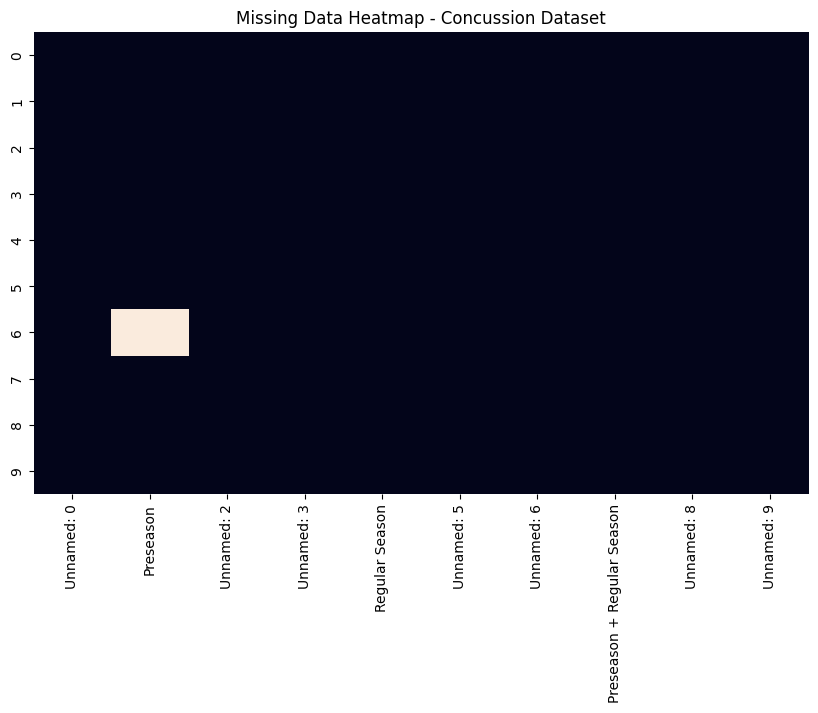

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(concussion.isnull(), cbar=False)
plt.title("Missing Data Heatmap - Concussion Dataset")
plt.show()


In [ ]:
# Drop empty columns
concussion_clean = concussion.dropna(axis=1, how='all')

print(concussion_clean.columns)
print(concussion_clean.head())


Index(['Unnamed: 0', 'Preseason', 'Unnamed: 2', 'Unnamed: 3', 'Regular Season',
       'Unnamed: 5', 'Unnamed: 6', 'Preseason + Regular Season', 'Unnamed: 8',
       'Unnamed: 9'],
      dtype='object')
  Unnamed: 0 Preseason Unnamed: 2 Unnamed: 3 Regular Season Unnamed: 5  \
0       Year      Game   Practice      Total           Game   Practice   
1       2015        54         29         83            183          9   
2       2016        45         26         71            166          6   
3       2017        46         45         91            179         11   
4       2018        34         45         79            127          8   

  Unnamed: 6 Preseason + Regular Season Unnamed: 8 Unnamed: 9  
0      Total                       Game   Practice      Total  
1        192                        237         38        275  
2        172                        211         32        243  
3        190                        225         56        281  
4        135                    

In [ ]:
import pandas as pd

# Load the file
concussion = pd.read_csv("NFL Concussion 2015-2023 (1).csv")

# Step 1: Replace the header with row 0
new_header = concussion.iloc[0]   # first row
concussion = concussion[1:]       # remove header row
concussion.columns = new_header   # set new header

# Step 2: Rename columns to clear names
concussion = concussion.rename(columns={
    "Year": "Year",
    "Game": "Preseason_Game",
    "Practice": "Preseason_Practice",
    "Total": "Preseason_Total",
    "Regular Season": "RegularSeason_Game",
    "Practice": "RegularSeason_Practice",
    "Total": "RegularSeason_Total",
    "Preseason + Regular Season": "Combined_Game",
    "Practice": "Combined_Practice",
    "Total": "Combined_Total",
})

# Problem: Duplicate column names ("Practice", "Total") were overwritten.
# So we re-read with correct mapping:

concussion = pd.read_csv("NFL Concussion 2015-2023 (1).csv")

# Use row 0 as header again
new_header = concussion.iloc[0]
concussion = concussion[1:]
concussion.columns = new_header

# Now rename uniquely
concussion.columns = [
    "Year",
    "Preseason_Game",
    "Preseason_Practice",
    "Preseason_Total",
    "RegularSeason_Game",
    "RegularSeason_Practice",
    "RegularSeason_Total",
    "Combined_Game",
    "Combined_Practice",
    "Combined_Total"
]

# Convert numeric columns
for col in concussion.columns:
    if col != "Year":
        concussion[col] = pd.to_numeric(concussion[col], errors='coerce')

print(concussion)
print(concussion.info())


   Year  Preseason_Game  Preseason_Practice  Preseason_Total  \
1  2015            54.0                  29               83   
2  2016            45.0                  26               71   
3  2017            46.0                  45               91   
4  2018            34.0                  45               79   
5  2019            49.0                  30               79   
6  2020             NaN                  30               30   
7  2021            22.0                  30               52   
8  2022            27.0                  25               52   
9  2023            32.0                  26               58   

   RegularSeason_Game  RegularSeason_Practice  RegularSeason_Total  \
1                 183                       9                  192   
2                 166                       6                  172   
3                 179                      11                  190   
4                 127                       8                  135   
5        

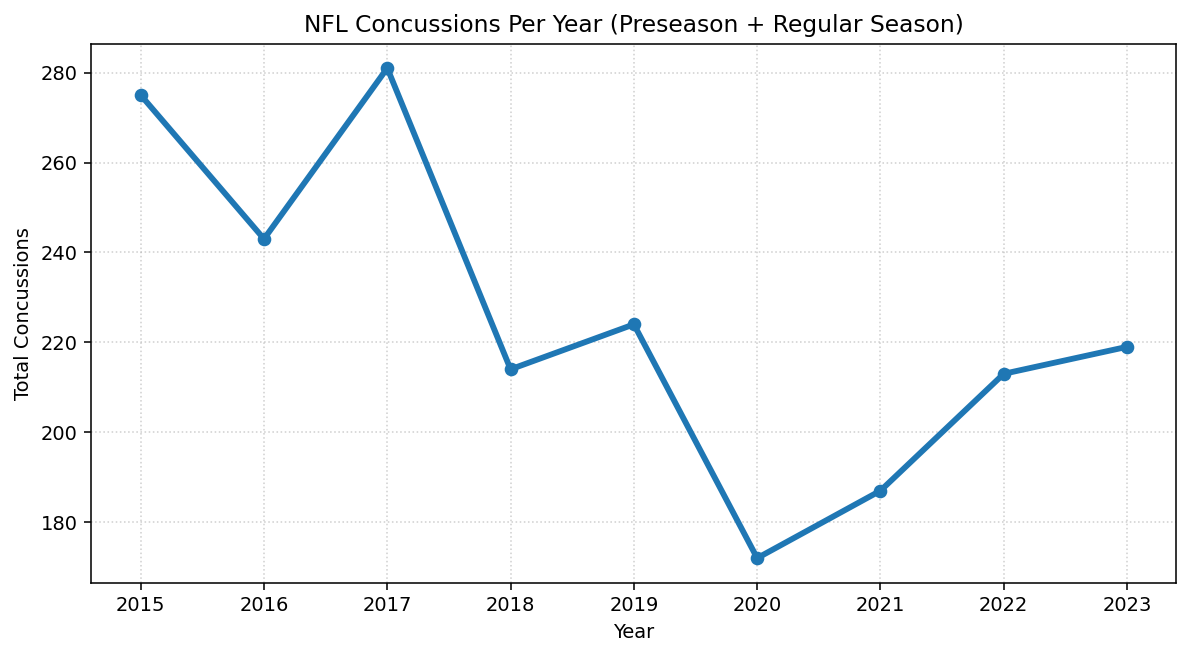

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=140)
plt.plot(concussion["Year"], concussion["Combined_Total"],
         linewidth=3, marker="o")

plt.title("NFL Concussions Per Year (Preseason + Regular Season)")
plt.xlabel("Year")
plt.ylabel("Total Concussions")
plt.grid(True, linestyle=":", alpha=0.6)
plt.show()


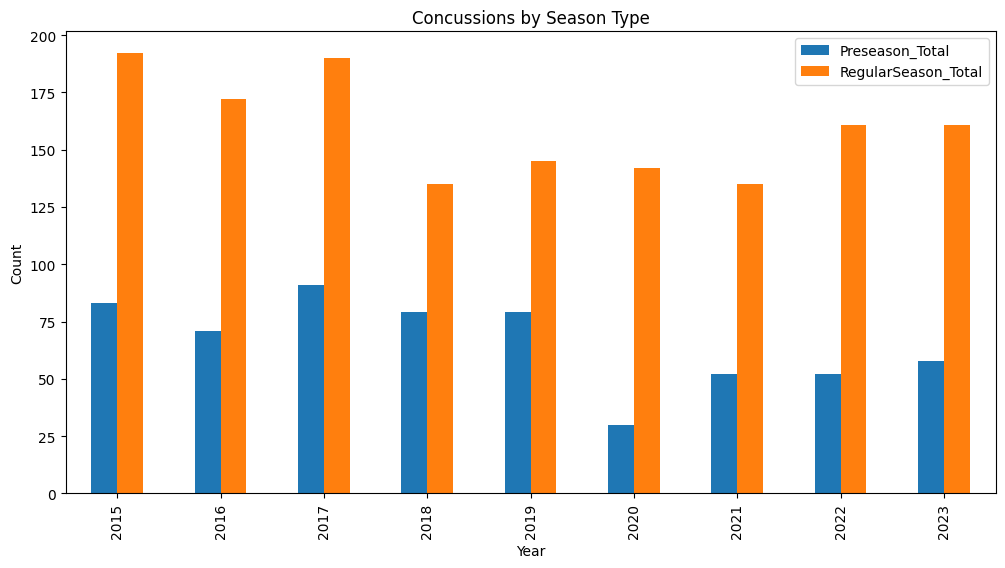

In [ ]:
concussion[["Year", "Preseason_Total", "RegularSeason_Total"]].plot(
    x="Year", kind="bar", figsize=(12,6)
)
plt.title("Concussions by Season Type")
plt.ylabel("Count")
plt.show()


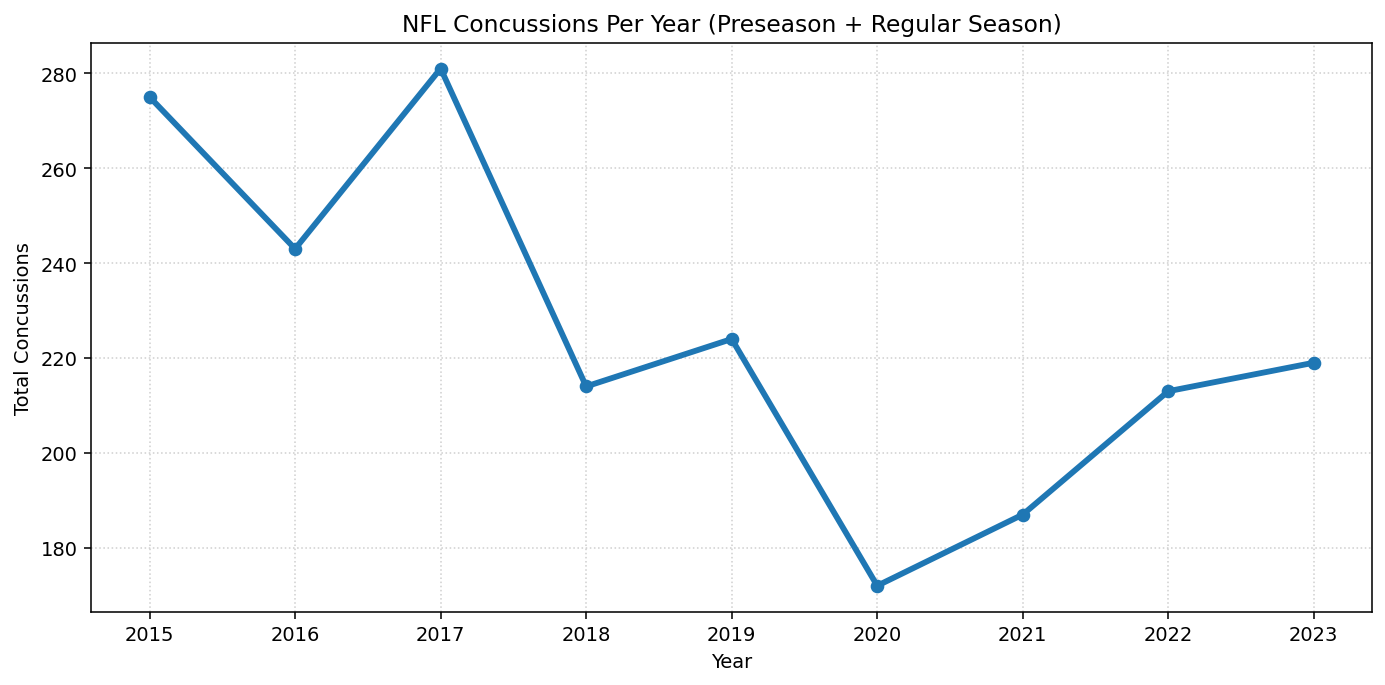

In [ ]:
plt.figure(figsize=(10,5), dpi=140)
plt.plot(concussion["Year"], concussion["Combined_Total"],
         linewidth=3, marker="o")

plt.title("NFL Concussions Per Year (Preseason + Regular Season)")
plt.xlabel("Year")
plt.ylabel("Total Concussions")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()


In [30]:
from google.colab import files
uploaded = files.upload()

Saving NFL Concussion 2015-2023.csv to NFL Concussion 2015-2023.csv


   Year  Preseason_Total  RegularSeason_Total  Combined_Total
0  2015               83                  192             275
1  2016               71                  172             243
2  2017               91                  190             281
3  2018               79                  135             214
4  2019               79                  145             224
5  2020               30                  142             172
6  2021               52                  135             187
7  2022               52                  161             213
8  2023               58                  161             219


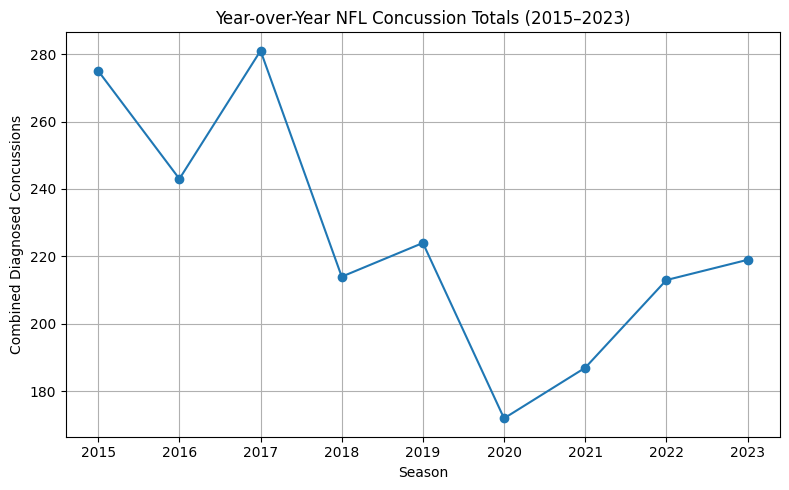

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset, explicitly setting header to None to read all rows as data
df = pd.read_csv("NFL Concussion 2015-2023.csv", header=None)

# Assign explicit column names based on the file structure
# This assumes the raw CSV has a header structure that needs manual interpretation
df.columns = [
    "Year",
    "Preseason_Game",
    "Preseason_Practice",
    "Preseason_Total",
    "RegularSeason_Game",
    "RegularSeason_Practice",
    "RegularSeason_Total",
    "Combined_Game",
    "Combined_Practice",
    "Combined_Total"
]

# Drop the original header rows (now row 0 and 1 after assigning names)
df = df.drop([0, 1]).reset_index(drop=True)

# Select the relevant columns after cleaning
df = df[["Year", "Preseason_Total", "RegularSeason_Total", "Combined_Total"]]

# Convert Year and numeric columns to appropriate types
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
for col in ["Preseason_Total", "RegularSeason_Total", "Combined_Total"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Sort by Year
df = df.sort_values("Year")

# Optional: print cleaned dataset
print(df)

# --- Plot Year-over-Year Concussion Totals ---
plt.figure(figsize=(8, 5))
plt.plot(df["Year"], df["Combined_Total"], marker="o")

plt.xlabel("Season")
plt.ylabel("Combined Diagnosed Concussions")
plt.title("Year-over-Year NFL Concussion Totals (2015–2023)")
plt.grid(True)
plt.tight_layout()
plt.show()

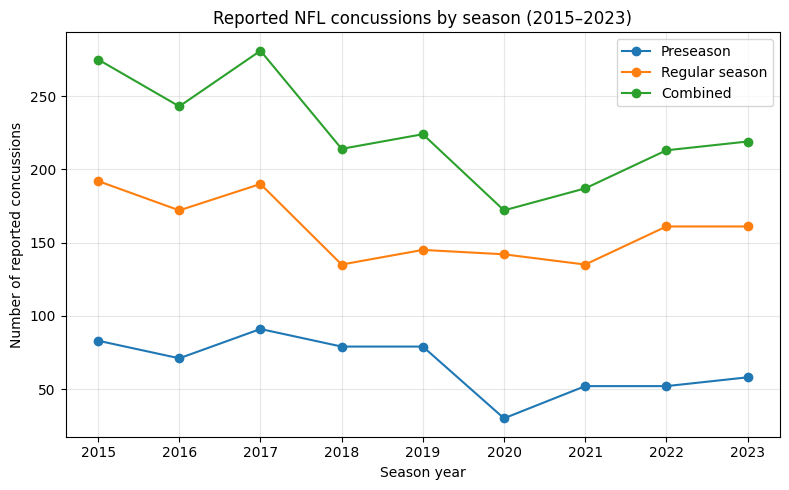

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset, explicitly setting header to None to read all rows as data
concussions = pd.read_csv("NFL Concussion 2015-2023.csv", header=None)

# Assign explicit column names based on the file structure
concussions.columns = [
    "Year",
    "Preseason_Game",
    "Preseason_Practice",
    "Preseason_Total",
    "RegularSeason_Game",
    "RegularSeason_Practice",
    "RegularSeason_Total",
    "Combined_Game",
    "Combined_Practice",
    "Combined_Total"
]

# Drop the original header rows (now row 0 and 1 after assigning names)
concussions = concussions.drop([0, 1]).reset_index(drop=True)

# Convert Year and numeric columns to appropriate types
concussions["Year"] = pd.to_numeric(concussions["Year"], errors="coerce")
for col in ["Preseason_Total", "RegularSeason_Total", "Combined_Total"]:
    concussions[col] = pd.to_numeric(concussions[col], errors="coerce")

# Sort by Year
concussions = concussions.sort_values("Year")

plt.figure(figsize=(8, 5))

plt.plot(concussions["Year"], concussions["Preseason_Total"], marker="o", label="Preseason")
plt.plot(concussions["Year"], concussions["RegularSeason_Total"], marker="o", label="Regular season")
plt.plot(concussions["Year"], concussions["Combined_Total"], marker="o", label="Combined")

plt.xlabel("Season year")
plt.ylabel("Number of reported concussions")
plt.title("Reported NFL concussions by season (2015–2023)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()